Import necessary packages for Task B

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import joblib
import shutil
import skimage
from collections import Counter

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression #did not converge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import accuracy_score

PREPROCESSING

Function to format all the tumour images convert them using imread and storing the resulting dict in a .pkl file

In [2]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})tumour images in rgb for Task B'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file), as_gray=True) #if doesn't work remove as_gray bit
                    im = resize(im, (width, height)) #[:,:,::-1] #for consistency
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

Sorting the images to four folders, tumour and no tumour

In [8]:
#Import label.csv file
data = pd.read_csv('label.csv')
#print(data) #debug line

#Give the image labels binary values based on tumour (1) or no tumour (0)
data.label[data.label == 'no_tumor'] = 0
data.label[data.label == 'meningioma_tumor'] = 1
data.label[data.label == 'glioma_tumor'] = 2
data.label[data.label == 'pituitary_tumor'] = 3
#print(data.dtypes) #debug line

#Convert the label data type to integer
data['label'] = data['label'].astype(str).astype(int)
#print(data.dtypes) #debug line
#print(data) #debug line

#Create four arrays which contain the respective image names 
no_tumour = []
meningioma_tumour = []
glioma_tumor = []
pituitary_tumor = []

for i in range(data.shape[0]):
    if data['label'][i] == 0:
        no_tumour.append(data['file_name'][i])
    elif data['label'][i] == 1:
        meningioma_tumour.append(data['file_name'][i])
    elif data['label'][i] == 2:
        glioma_tumor.append(data['file_name'][i])
    else:
        pituitary_tumor.append(data['file_name'][i])

#print(len(no_tumour)) #debug line
#print(len(meningioma_tumour)) #debug line
#print(len(glioma_tumor)) #debug line
#print(len(pituitary_tumor)) #debug line

#Create a sorted subfolder to store the sorted images
os.mkdir(os.path.join("./image", "sorted_TaskB"))

#Create four subfolders in sorted folder
os.mkdir(os.path.join("./image/sorted_TaskB", "no_tumour"))
os.mkdir(os.path.join("./image/sorted_TaskB", "meningioma_tumour"))
os.mkdir(os.path.join("./image/sorted_TaskB", "glioma_tumor"))
os.mkdir(os.path.join("./image/sorted_TaskB", "pituitary_tumor"))

#Copy the images into the respective subfolders
src_dir = "./image"
dst_dir1 = os.path.join("./image/sorted_TaskB", "no_tumour")
dst_dir2 = os.path.join("./image/sorted_TaskB", "meningioma_tumour")
dst_dir3 = os.path.join("./image/sorted_TaskB", "glioma_tumor")
dst_dir4 = os.path.join("./image/sorted_TaskB", "pituitary_tumor")
data_path = "./image/sorted_TaskB"

for imageName in no_tumour:
    shutil.copy(os.path.join(src_dir, imageName), dst_dir1)

for imageName in meningioma_tumour:
    shutil.copy(os.path.join(src_dir, imageName), dst_dir2)

for imageName in glioma_tumor:
    shutil.copy(os.path.join(src_dir, imageName), dst_dir3)

for imageName in pituitary_tumor:
    shutil.copy(os.path.join(src_dir, imageName), dst_dir4)

#os.listdir(data_path)  #debug line

#Initialising Parameters for resize function
base_name = 'tumour_images_dataset_TaskB'
width = 256 #Kapernikov has 80 
include = {'glioma_tumor', 'meningioma_tumour', 'no_tumour', 'pituitary_tumor'}
 
#Create pkl file with resized images resized and converted to arrays
resize_all(src=data_path, pklname=base_name, width=width, include=include)

glioma_tumor
meningioma_tumour
no_tumour
pituitary_tumor


In [ ]:
#Run this and skip previous cell if pkl file already exists
#Initialising Parameters for resize function
base_name = 'tumour_images_dataset_TaskB'
width = 256 #Kapernikov has 80 
include = {'glioma_tumor', 'meningioma_tumour', 'no_tumour', 'pituitary_tumor'}

Some data analysis stuff

number of samples:  3000
keys:  ['description', 'label', 'filename', 'data']
description:  resized (256x256)tumour images in rgb for Task B
image shape:  (256, 256)
labels: ['glioma_t' 'meningioma_tu' 'no_tu' 'pituitary_t']


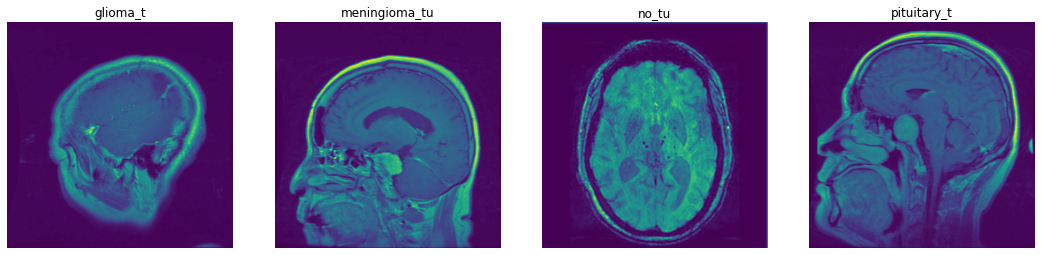

In [9]:
#Load pickle data file
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

#some information abour the data
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

#Display an image for each label
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Data preparation

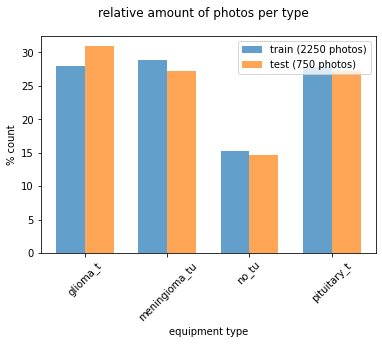

In [10]:
#Extracting the X and y values from data
X = np.array(data['data'])
y = np.array(data['label'])

#Split data to train and test (75% train, 25% split)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    shuffle=True,
    random_state=42,
)

#Plotting the train/test split data
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

Create the classes on the transformers

In [11]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Prepare training data

In [12]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    #change parameters below for optimisation
    pixels_per_cell=(8, 8), 
    cells_per_block=(3,3), 
    orientations=8, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
#X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train.shape)
print(X_train_prepared.shape) 

(2250, 256, 256)
(2250, 64800)


Prepare test data

In [13]:
#X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

print(X_test_prepared.shape) 

(750, 64800)


Implement PCA to reduce number of features

In [14]:
#create pca instance with 95% variance retention
pca = PCA(.95)
pca.fit(X_train_prepared)

#number of features selected
print(pca.n_components_)

NewX_train_prepared = pca.transform(X_train_prepared)
NewX_test_prepared = pca.transform(X_test_prepared)

print(NewX_train_prepared.shape) 
print(NewX_test_prepared.shape) 

1467
(2250, 1467)
(750, 1467)


Different variance retention + K-Nearest Neighbours

0.8
722
(2250, 722)
(750, 722)
For k = 1
Percentage correct:  92.66666666666667
confusion matrix is:
[[222   2   7   1]
 [  7 188   2   7]
 [  8   5  84  13]
 [  1   2   0 201]]

For k = 2
Percentage correct:  88.8
confusion matrix is:
[[227   0   4   1]
 [ 30 166   1   7]
 [ 15   9  75  11]
 [  2   3   1 198]]

For k = 3
Percentage correct:  87.2
confusion matrix is:
[[212   8   7   5]
 [ 20 164   1  19]
 [  9   8  77  16]
 [  2   1   0 201]]

For k = 4
Percentage correct:  84.8
confusion matrix is:
[[217   7   4   4]
 [ 25 156   5  18]
 [ 18   8  67  17]
 [  6   2   0 196]]

For k = 5
Percentage correct:  82.8
confusion matrix is:
[[203  17   5   7]
 [ 22 152   4  26]
 [ 14   8  68  20]
 [  6   0   0 198]]

For k = 6
Percentage correct:  81.06666666666666
confusion matrix is:
[[207  12   6   7]
 [ 32 141   5  26]
 [ 17   5  65  23]
 [  6   3   0 195]]

For k = 7
Percentage correct:  80.26666666666667
confusion matrix is:
[[197  20   6   9]
 [ 26 139   7  32]
 [ 11   7  70  22]
 [  6 

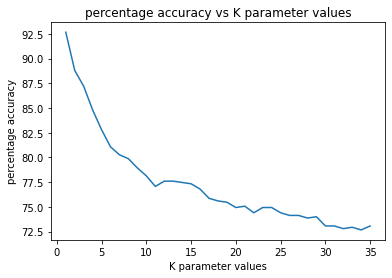

0.85
906
(2250, 906)
(750, 906)
For k = 1
Percentage correct:  92.8
confusion matrix is:
[[221   2   7   2]
 [  9 187   1   7]
 [  7   4  86  13]
 [  1   1   0 202]]

For k = 2
Percentage correct:  89.6
confusion matrix is:
[[227   0   4   1]
 [ 26 170   3   5]
 [ 15   8  76  11]
 [  2   2   1 199]]

For k = 3
Percentage correct:  87.2
confusion matrix is:
[[212   8   6   6]
 [ 20 162   2  20]
 [  9   5  78  18]
 [  2   0   0 202]]

For k = 4
Percentage correct:  84.93333333333334
confusion matrix is:
[[219   4   4   5]
 [ 29 151   4  20]
 [ 17   6  69  18]
 [  5   1   0 198]]

For k = 5
Percentage correct:  82.26666666666667
confusion matrix is:
[[205  14   6   7]
 [ 25 145   5  29]
 [ 15   8  68  19]
 [  5   0   0 199]]

For k = 6
Percentage correct:  80.93333333333334
confusion matrix is:
[[205  12   7   8]
 [ 34 138   5  27]
 [ 18   2  67  23]
 [  5   2   0 197]]

For k = 7
Percentage correct:  81.06666666666666
confusion matrix is:
[[200  17   6   9]
 [ 27 138   7  32]
 [ 10   4  

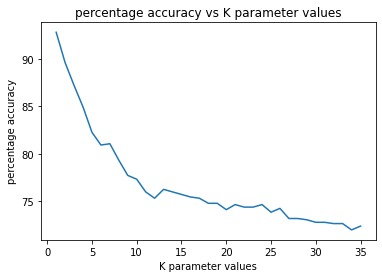

0.9
1142
(2250, 1142)
(750, 1142)
For k = 1
Percentage correct:  92.4
confusion matrix is:
[[221   3   7   1]
 [ 10 185   2   7]
 [  7   3  86  14]
 [  1   1   1 201]]

For k = 2
Percentage correct:  89.6
confusion matrix is:
[[228   0   3   1]
 [ 27 168   2   7]
 [ 14   8  77  11]
 [  2   2   1 199]]

For k = 3
Percentage correct:  87.73333333333333
confusion matrix is:
[[212   8   7   5]
 [ 17 162   4  21]
 [  7   3  82  18]
 [  2   0   0 202]]

For k = 4
Percentage correct:  84.93333333333334
confusion matrix is:
[[216   4   6   6]
 [ 32 147   4  21]
 [ 13   4  75  18]
 [  5   0   0 199]]

For k = 5
Percentage correct:  82.93333333333334
confusion matrix is:
[[204  13   8   7]
 [ 26 144   6  28]
 [  9   5  75  21]
 [  5   0   0 199]]

For k = 6
Percentage correct:  81.46666666666667
confusion matrix is:
[[205  12   8   7]
 [ 33 135   7  29]
 [ 11   3  74  22]
 [  5   2   0 197]]

For k = 7
Percentage correct:  79.73333333333333
confusion matrix is:
[[192  19  10  11]
 [ 23 134  10  

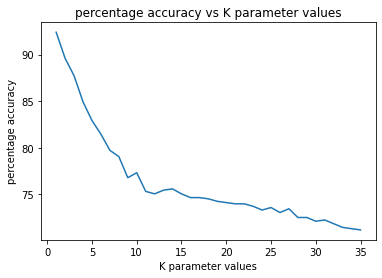

0.95
1467
(2250, 1467)
(750, 1467)
For k = 1
Percentage correct:  92.66666666666667
confusion matrix is:
[[219   3   9   1]
 [  8 187   4   5]
 [  5   5  87  13]
 [  1   0   1 202]]

For k = 2
Percentage correct:  88.93333333333334
confusion matrix is:
[[222   0   9   1]
 [ 29 166   4   5]
 [ 11   6  80  13]
 [  2   2   1 199]]

For k = 3
Percentage correct:  87.46666666666667
confusion matrix is:
[[206   9  11   6]
 [ 15 163   5  21]
 [  4   2  86  18]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.6
confusion matrix is:
[[213   3  10   6]
 [ 27 150   5  22]
 [  8   2  81  19]
 [  5   0   1 198]]

For k = 5
Percentage correct:  82.93333333333334
confusion matrix is:
[[201  12  13   6]
 [ 26 142   6  30]
 [  5   2  81  22]
 [  5   0   1 198]]

For k = 6
Percentage correct:  81.33333333333333
confusion matrix is:
[[202  10  14   6]
 [ 32 134   6  32]
 [  6   4  78  22]
 [  5   2   1 196]]

For k = 7
Percentage correct:  78.8
confusion matrix is:
[[187  19  14  12]
 [ 24 128  14 

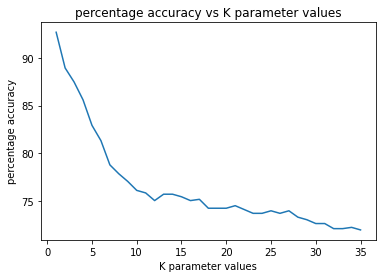

0.975
1693
(2250, 1693)
(750, 1693)
For k = 1
Percentage correct:  93.2
confusion matrix is:
[[220   2   9   1]
 [  8 187   4   5]
 [  3   3  91  13]
 [  1   1   1 201]]

For k = 2
Percentage correct:  89.86666666666666
confusion matrix is:
[[222   0   9   1]
 [ 29 166   4   5]
 [  5   5  87  13]
 [  2   2   1 199]]

For k = 3
Percentage correct:  88.4
confusion matrix is:
[[211   7  11   3]
 [ 16 163   5  20]
 [  2   2  88  18]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.46666666666667
confusion matrix is:
[[213   3  10   6]
 [ 26 151   7  20]
 [  6   5  80  19]
 [  5   1   1 197]]

For k = 5
Percentage correct:  82.4
confusion matrix is:
[[198  13  13   8]
 [ 20 140  12  32]
 [  5   3  82  20]
 [  5   0   1 198]]

For k = 6
Percentage correct:  81.06666666666666
confusion matrix is:
[[199  12  14   7]
 [ 25 134  11  34]
 [  7   3  79  21]
 [  5   2   1 196]]

For k = 7
Percentage correct:  78.93333333333334
confusion matrix is:
[[186  19  15  12]
 [ 18 129  17  40]
 [  5  

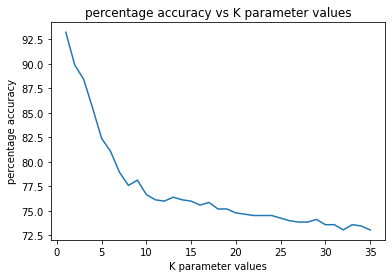

0.99
1870
(2250, 1870)
(750, 1870)
For k = 1
Percentage correct:  93.46666666666667
confusion matrix is:
[[220   2  10   0]
 [  8 187   4   5]
 [  2   2  93  13]
 [  1   1   1 201]]

For k = 2
Percentage correct:  90.4
confusion matrix is:
[[222   0  10   0]
 [ 28 167   4   5]
 [  3   5  90  12]
 [  2   2   1 199]]

For k = 3
Percentage correct:  88.66666666666667
confusion matrix is:
[[211   7  12   2]
 [ 15 165   5  19]
 [  1   3  88  18]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.73333333333333
confusion matrix is:
[[213   3  11   5]
 [ 24 152   8  20]
 [  6   7  81  16]
 [  5   1   1 197]]

For k = 5
Percentage correct:  83.2
confusion matrix is:
[[198  14  13   7]
 [ 15 144  13  32]
 [  5   3  84  18]
 [  5   0   1 198]]

For k = 6
Percentage correct:  81.33333333333333
confusion matrix is:
[[199  13  16   4]
 [ 25 135  12  32]
 [  7   3  80  20]
 [  5   2   1 196]]

For k = 7
Percentage correct:  79.2
confusion matrix is:
[[188  19  15  10]
 [ 18 129  21  36]
 [  6   

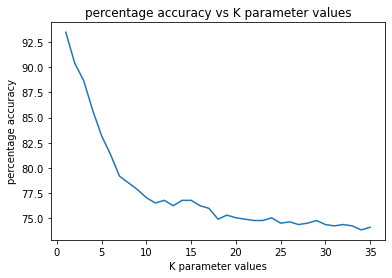

In [15]:
var_val = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]

def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    y_pred_knn = neigh.predict(X_test)
    return y_pred_knn

precentage = np.zeros(35)

for i in var_val:
    pca = PCA(i)
    pca.fit(X_train_prepared)

    #number of features selected
    print(i)
    print(pca.n_components_)

    NewX_train_prepared = pca.transform(X_train_prepared)
    NewX_test_prepared = pca.transform(X_test_prepared)

    print(NewX_train_prepared.shape) 
    print(NewX_test_prepared.shape)
    
    for j in range(1,36):
        y_pred_knn=KNNClassifier(NewX_train_prepared, y_train, NewX_test_prepared,j)
        print('For k =', j)
        precentage[j-1]=100*np.sum(y_pred_knn == y_test)/len(y_test)
        print('Percentage correct: ', precentage[j-1])
        cmx_knn = confusion_matrix(y_test, y_pred_knn)
        print('confusion matrix is:')
        print(cmx_knn)
        print('')
    
    #plot the accuracy of K
    K_values = np.linspace(1, 35, num=35)
    plt.plot(K_values,precentage)
    plt.xlabel("K parameter values")
    plt.ylabel("percentage accuracy")
    plt.title("percentage accuracy vs K parameter values")
    plt.show()

Decision Tree

In [16]:
split_params = [2, 5, 10, 20, 25, 50]

for i in split_params:
    tree_params={
        'criterion': 'entropy',
        'min_samples_split':i
    }
    clf_tree = tree.DecisionTreeClassifier(**tree_params)
    clf_tree.fit(NewX_train_prepared, y_train)

    print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf_tree.predict(NewX_train_prepared)))
    print('Accuracy Score on the test data: ', accuracy_score(y_true=y_test, y_pred=clf_tree.predict(NewX_test_prepared)))

    y_pred_test = clf_tree.predict(NewX_test_prepared)
    print(np.array(y_pred_test == y_test)[:25])
    print('')
    print('Percentage correct: ', 100*np.sum(y_pred_test == y_test)/len(y_test))

    cmx_tree = confusion_matrix(y_test, y_pred_test)
    print(cmx_tree)
    print('')

Accuracy Score on train data:  1.0
Accuracy Score on the test data:  0.7506666666666667
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True False  True False  True False
 False]

Percentage correct:  75.06666666666666
[[162  50  10  10]
 [ 31 145   4  24]
 [ 13  17  73   7]
 [  4   9   8 183]]

Accuracy Score on train data:  0.9924444444444445
Accuracy Score on the test data:  0.7506666666666667
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True False  True False  True False
 False]

Percentage correct:  75.06666666666666
[[165  45  12  10]
 [ 32 144   4  24]
 [ 12  21  70   7]
 [  4   9   7 184]]

Accuracy Score on train data:  0.9737777777777777
Accuracy Score on the test data:  0.7546666666666667
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True False  True False  True False
 False]

Percent

SGD Method

In [17]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

cmx = confusion_matrix(y_test, y_pred)
print(cmx)

[ True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
 False]

Percentage correct:  86.93333333333334
[[191  26  10   5]
 [ 15 165  12  12]
 [  2   0 101   7]
 [  6   3   0 195]]


In [18]:
sgd_clf.fit(NewX_train_prepared, y_train)

y_pred = sgd_clf.predict(NewX_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

cmx = confusion_matrix(y_test, y_pred)
print(cmx)

[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True]

Percentage correct:  86.8
[[193  23  10   6]
 [ 19 164  12   9]
 [  4   3  96   7]
 [  5   1   0 198]]
